In [33]:
from pathlib import Path
import pandas as pd

ROOT = Path.cwd()
while not (ROOT / "README.md").exists() and ROOT != ROOT.parent:
    ROOT = ROOT.parent

print("Repo root:", ROOT)

UNDERSTAT_DIR = ROOT / "understat_data"
MATCHES_PATH = UNDERSTAT_DIR / "Dataset_Version_7.csv"
OUTPUT_PATH = ROOT / "data" / "processed" / "financial_dataset.csv"

MATCHES_PATH, OUTPUT_PATH

Repo root: C:\SFUFall2024\CMPT732\pythonProject\The-Beautiful-Game-Oracle-main


(WindowsPath('C:/SFUFall2024/CMPT732/pythonProject/The-Beautiful-Game-Oracle-main/understat_data/Dataset_Version_7.csv'),
 WindowsPath('C:/SFUFall2024/CMPT732/pythonProject/The-Beautiful-Game-Oracle-main/data/processed/financial_dataset.csv'))

In [34]:
df_matches = pd.read_csv(MATCHES_PATH)

df_matches = df_matches[[
    "match_id",
    "season",
    "match_date",
    "home_team_name",
    "away_team_name",
    "outcome_label",  
]]

df_matches = df_matches.rename(columns={
    "match_date": "date",
    "home_team_name": "home_team",
    "away_team_name": "away_team",
    "outcome_label": "target",
})

df_matches.head()

,match_id,season,date,home_team,away_team,target
0,18202,2022,2022-08-05,Crystal Palace,Arsenal,A
1,18203,2022,2022-08-06,Fulham,Liverpool,D
2,18204,2022,2022-08-06,Bournemouth,Aston Villa,H
3,18205,2022,2022-08-06,Leeds,Wolverhampton Wanderers,H
4,18206,2022,2022-08-06,Newcastle United,Nottingham Forest,H


In [35]:
sorted(df_matches["home_team"].unique().tolist())

['Arsenal',
 'Aston Villa',
 'Bournemouth',
 'Brentford',
 'Brighton',
 'Burnley',
 'Chelsea',
 'Crystal Palace',
 'Everton',
 'Fulham',
 'Ipswich',
 'Leeds',
 'Leicester',
 'Liverpool',
 'Luton',
 'Manchester City',
 'Manchester United',
 'Newcastle United',
 'Nottingham Forest',
 'Sheffield United',
 'Southampton',
 'Sunderland',
 'Tottenham',
 'West Ham',
 'Wolverhampton Wanderers']

In [36]:
sorted(df_matches["away_team"].unique().tolist())

['Arsenal',
 'Aston Villa',
 'Bournemouth',
 'Brentford',
 'Brighton',
 'Burnley',
 'Chelsea',
 'Crystal Palace',
 'Everton',
 'Fulham',
 'Ipswich',
 'Leeds',
 'Leicester',
 'Liverpool',
 'Luton',
 'Manchester City',
 'Manchester United',
 'Newcastle United',
 'Nottingham Forest',
 'Sheffield United',
 'Southampton',
 'Sunderland',
 'Tottenham',
 'West Ham',
 'Wolverhampton Wanderers']

In [37]:
# All team names in *your* dataset (canonical form)
match_team_names = sorted(df_matches["home_team"].unique().tolist())
print("Match dataset team names:")
for n in match_team_names:
    print(" -", n)

# dict map 
TEAM_NAME_MAP = {
    # Transfermarkt names : match dataset names
    "Man City": "Manchester City",
    "Man Utd": "Manchester United",
    "Newcastle": "Newcastle United",
    "Nott'm Forest": "Nottingham Forest",
    "Wolves": "Wolverhampton Wanderers",

    # Capology names : match dataset names
    "Ipswich Town": "Ipswich",
    "Luton Town": "Luton",
    "Wolverhampton": "Wolverhampton Wanderers",
}

def normalize_team_name(name: str) -> str:
    """Map Transfermarkt/FBref Capology team names into your match dataset naming scheme."""
    if pd.isna(name):
        return name
    name = name.strip()
    return TEAM_NAME_MAP.get(name, name)


Match dataset team names:
 - Arsenal
 - Aston Villa
 - Bournemouth
 - Brentford
 - Brighton
 - Burnley
 - Chelsea
 - Crystal Palace
 - Everton
 - Fulham
 - Ipswich
 - Leeds
 - Leicester
 - Liverpool
 - Luton
 - Manchester City
 - Manchester United
 - Newcastle United
 - Nottingham Forest
 - Sheffield United
 - Southampton
 - Sunderland
 - Tottenham
 - West Ham
 - Wolverhampton Wanderers


In [38]:
import sys
import subprocess

def pip_install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# ScraperFC 
try:
    import ScraperFC
except ImportError:
    pip_install("ScraperFC")
    import ScraperFC

from ScraperFC.transfermarkt import Transfermarkt
from ScraperFC.fbref import FBref

print("ScraperFC imported successfully.")

ScraperFC imported successfully.


In [39]:
tm = Transfermarkt()

league_code = "EPL"  

valid_seasons = tm.get_valid_seasons(league_code)
print("Valid seasons for league", league_code, ":\n", valid_seasons)


Valid seasons for league EPL :
 {'25/26': '2025', '24/25': '2024', '23/24': '2023', '22/23': '2022', '21/22': '2021', '20/21': '2020', '19/20': '2019', '18/19': '2018', '17/18': '2017', '16/17': '2016', '15/16': '2015', '14/15': '2014', '13/14': '2013', '12/13': '2012', '11/12': '2011', '10/11': '2010', '09/10': '2009', '08/09': '2008', '07/08': '2007', '06/07': '2006', '05/06': '2005', '04/05': '2004', '03/04': '2003', '02/03': '2002', '01/02': '2001', '00/01': '2000', '99/00': '1999', '98/99': '1998', '97/98': '1997', '96/97': '1996', '95/96': '1995', '94/95': '1994', '93/94': '1993', '92/93': '1992'}


In [40]:
# Reverse map.
tm_year_to_code = {str(year): season_code for season_code, year in valid_seasons.items()}
print("\nTransfermarkt year -> season_code mapping:")
print(tm_year_to_code)

# Seasons present in matches file
match_seasons_raw = sorted(df_matches["season"].astype(str).unique().tolist())
print("\nSeasons in df_matches:", match_seasons_raw)

# map to Transfermarkt season:
season_codes_to_scrape = []
for year in match_seasons_raw:
    code = tm_year_to_code.get(year)
    if code is not None:
        season_codes_to_scrape.append(code)

season_codes_to_scrape = sorted(set(season_codes_to_scrape))
print("\nTransfermarkt season codes we will scrape:", season_codes_to_scrape)



Transfermarkt year -> season_code mapping:
{'2025': '25/26', '2024': '24/25', '2023': '23/24', '2022': '22/23', '2021': '21/22', '2020': '20/21', '2019': '19/20', '2018': '18/19', '2017': '17/18', '2016': '16/17', '2015': '15/16', '2014': '14/15', '2013': '13/14', '2012': '12/13', '2011': '11/12', '2010': '10/11', '2009': '09/10', '2008': '08/09', '2007': '07/08', '2006': '06/07', '2005': '05/06', '2004': '04/05', '2003': '03/04', '2002': '02/03', '2001': '01/02', '2000': '00/01', '1999': '99/00', '1998': '98/99', '1997': '97/98', '1996': '96/97', '1995': '95/96', '1994': '94/95', '1993': '93/94', '1992': '92/93'}

Seasons in df_matches: ['2022', '2023', '2024', '2025']

Transfermarkt season codes we will scrape: ['22/23', '23/24', '24/25', '25/26']


In [41]:
import os

CACHE_DIR = ROOT / "data" / "external" / "tm_players_cache"
CACHE_DIR.mkdir(parents=True, exist_ok=True)

def scrape_or_load_players(year_code, league_code="EPL"):
    # FIX: Replace slash in season code
    safe_code = year_code.replace("/", "_")

    cache_path = CACHE_DIR / f"tm_players_{league_code}_{safe_code}.pkl"

    if cache_path.exists():
        print(f"Loading players from cache for {league_code} {year_code}: {cache_path}")
        return pd.read_pickle(cache_path)

    print(f"Scraping players for {league_code} {year_code} (no cache yet)...")
    players_df = tm.scrape_players(year=year_code, league=league_code)
    print("Scraped rows:", len(players_df))

    try:
        players_df.to_pickle(cache_path)
        print("Saved cache to:", cache_path)
    except Exception as e:
        print("Warning: could not cache players due to:", repr(e))

    return players_df


In [42]:
season_codes_to_scrape = ['22/23', '23/24', '24/25', '25/26'] #for now to just test

import numpy as np

def parse_market_value(value):
    """
    Convert market value strings like '€50.0m' or '€800k' to numeric EUR.
    """
    if isinstance(value, (int, float, np.number)):
        return float(value)
    if not isinstance(value, str):
        return np.nan

    s = value.replace("€", "").replace(",", "").strip().lower()
    factor = 1.0
    if s.endswith("m"):
        factor = 1e6
        s = s[:-1]
    elif s.endswith("k"):
        factor = 1e3
        s = s[:-1]

    try:
        return float(s) * factor
    except ValueError:
        return np.nan


def scrape_club_season_values_tm(season_codes, league_code="EPL"):
    """
    For each Transfermarkt season code (e.g., '22/23'),
    use cached player data if available, otherwise scrape once.
    Aggregate to club-season squad_value_eur / avg_player_value_eur / squad_size,
    after deduplicating players per (ID, Team).
    """
    all_records = []

    for code in season_codes:
        print(f"\n=== Processing season code {code} ===")
        players_df = scrape_or_load_players(code, league_code=league_code)

        team_col = "Team"
        value_col = "Value"

        # Keep only relevant columns
        cols_to_keep = [team_col, value_col, "ID"]
        if "Value last updated" in players_df.columns:
            cols_to_keep.append("Value last updated")

        df = players_df[cols_to_keep].dropna(subset=[team_col, value_col, "ID"]).copy()

        # Deduplicate: one row per (ID, Team), keep the latest if we have a timestamp
        if "Value last updated" in df.columns:
            df = df.sort_values("Value last updated")
        df = df.drop_duplicates(subset=["ID", team_col], keep="last")

        # Parse market values to numeric euros
        df[value_col] = df[value_col].apply(parse_market_value)

        grouped = df.groupby(team_col).agg(
            squad_value_eur=(value_col, "sum"),
            avg_player_value_eur=(value_col, "mean"),
            squad_size=(value_col, "count"),
        ).reset_index()

        grouped["season_code"] = code  # '22/23', '23/24', '24/25', '25/26'
        grouped["season"] = grouped["season_code"].map(valid_seasons).astype(str)
        grouped = grouped.rename(columns={team_col: "team_tm"})
        all_records.append(grouped)

    return pd.concat(all_records, ignore_index=True)


In [43]:
team_season_fin_tm = scrape_club_season_values_tm(season_codes_to_scrape, league_code=league_code)
team_season_fin_tm.head(20)


=== Processing season code 22/23 ===
Scraping players for EPL 22/23 (no cache yet)...


22/23 EPL players: 100%|███████████████████████████████████████████████████████████| 1559/1559 [19:53<00:00,  1.31it/s]


Scraped rows: 1559
Saved cache to: C:\SFUFall2024\CMPT732\pythonProject\The-Beautiful-Game-Oracle-main\data\external\tm_players_cache\tm_players_EPL_22_23.pkl

=== Processing season code 23/24 ===
Scraping players for EPL 23/24 (no cache yet)...


23/24 EPL players: 100%|███████████████████████████████████████████████████████| 1619/1619 [18:37<00:00,  1.45it/s]


Scraped rows: 1619
Saved cache to: C:\SFUFall2024\CMPT732\pythonProject\The-Beautiful-Game-Oracle-main\data\external\tm_players_cache\tm_players_EPL_23_24.pkl

=== Processing season code 24/25 ===
Scraping players for EPL 24/25 (no cache yet)...


24/25 EPL players: 100%|███████████████████████████████████████████████████████████| 1470/1470 [16:12<00:00,  1.51it/s]


Scraped rows: 1470
Saved cache to: C:\SFUFall2024\CMPT732\pythonProject\The-Beautiful-Game-Oracle-main\data\external\tm_players_cache\tm_players_EPL_24_25.pkl

=== Processing season code 25/26 ===
Loading players from cache for EPL 25/26: C:\SFUFall2024\CMPT732\pythonProject\The-Beautiful-Game-Oracle-main\data\external\tm_players_cache\tm_players_EPL_25_26.pkl


,team_tm,squad_value_eur,avg_player_value_eur,squad_size,season_code,season
0,A. Klagenfurt,125000.0,1.250000e+05,1,22/23,2022
1,AC Milan,92000000.0,3.066667e+07,3,22/23,2022
2,ADO Den Haag,275000.0,2.750000e+05,1,22/23,2022
3,AEK Athens,2500000.0,2.500000e+06,1,22/23,2022
4,AFC Wimbledon,275000.0,2.750000e+05,1,22/23,2022
5,AJ Auxerre,5000000.0,5.000000e+06,1,22/23,2022
6,Aberdeen FC,700000.0,7.000000e+05,1,22/23,2022
7,Ajax,4000000.0,4.000000e+06,1,22/23,2022
8,Al-Ahli,38000000.0,1.266667e+07,3,22/23,2022
9,Al-Ahli SC,4000000.0,4.000000e+06,1,22/23,2022


In [44]:
players_df = scrape_or_load_players("25/26", "EPL")
players_df.head()

Loading players from cache for EPL 25/26: C:\SFUFall2024\CMPT732\pythonProject\The-Beautiful-Game-Oracle-main\data\external\tm_players_cache\tm_players_EPL_25_26.pkl


,Name,ID,Value,Value last updated,DOB,Age,Height (m),Nationality,Citizenship,Position,Other positions,Team,Last club,Since,Joined,Contract expiration,Market value history,Transfer history
0,Tino Livramento,503981,€40.00m,"May 30, 2025","Nov 12, 2002",23,1.82,England,[],Right-Back,None,Newcastle,None,None,"Aug 8, 2023","Jun 30, 2028",None,"Empty DataFrame Columns: [Season, Date, Left, ..."
1,Malo Gusto,620322,€35.00m,"May 30, 2025","May 19, 2003",22,1.78,France,[],Right-Back,None,Chelsea,None,None,"Jan 29, 2023","Jun 30, 2030",None,"Empty DataFrame Columns: [Season, Date, Left, ..."
2,John McGinn,193116,€16.00m,"May 30, 2025","Oct 18, 1994",31,1.78,Scotland,[],Central Midfield,None,Aston Villa,None,None,"Aug 8, 2018","Jun 30, 2028",None,"Empty DataFrame Columns: [Season, Date, Left, ..."
3,Tim Iroegbunam,696589,€11.00m,"Oct 17, 2025","Jun 30, 2003",22,1.83,England,[],Central Midfield,None,Everton,None,None,"Jul 1, 2024","Jun 30, 2027",None,"Empty DataFrame Columns: [Season, Date, Left, ..."
4,Joe Rodon,297212,€10.00m,"May 27, 2025","Oct 22, 1997",28,1.93,Wales,[Wales],Centre-Back,None,Leeds,None,None,"Jul 2, 2024","Jun 30, 2028",None,"Empty DataFrame Columns: [Season, Date, Left, ..."


In [45]:
from ScraperFC.capology import Capology

cap = Capology()

league_code = "EPL" 

# Available seasons Capology 
cap_valid_seasons = cap.get_valid_seasons(league_code)
print("Capology valid seasons for", league_code, ":", cap_valid_seasons)

# Seasons present in dataset
match_seasons = sorted(df_matches["season"].astype(str).unique().tolist())
print("Match seasons:", match_seasons)

# Capology seasons that match dataset
cap_seasons_to_scrape = []
for s in cap_valid_seasons:
    for year in match_seasons:
        if year in s:   # '2024' in '24/25' or '2024-2025'
            cap_seasons_to_scrape.append(s)

cap_seasons_to_scrape = sorted(set(cap_seasons_to_scrape))
# cap_seasons_to_scrape = ['2025-26'] # test 
print("Capology seasons we will scrape:", cap_seasons_to_scrape)

Capology valid seasons for EPL : ['2025-26', '2024-25', '2023-24', '2022-23', '2021-22', '2020-21', '2019-20', '2018-19', '2017-18', '2016-17', '2015-16', '2014-15', '2013-14']
Match seasons: ['2022', '2023', '2024', '2025']
Capology seasons we will scrape: ['2022-23', '2023-24', '2024-25', '2025-26']


In [46]:
# Cache for Capology salaries 
CAPOLOGY_CACHE_DIR = ROOT / "data" / "external" / "capology_cache"
CAPOLOGY_CACHE_DIR.mkdir(parents=True, exist_ok=True)

print("Capology cache dir:", CAPOLOGY_CACHE_DIR)

def capology_scrape_or_load(year_code, league_code="EPL", currency="eur"):
    """
    Load Capology salaries for (league, year_code) from cache if present.
    Otherwise scrape once and save to disk.
    """
    cache_path = CAPOLOGY_CACHE_DIR / f"capology_salaries_{league_code}_{year_code}.csv"

    if cache_path.exists():
        print(f"Loading Capology salaries from cache: {cache_path}")
        return pd.read_csv(cache_path)

    print(f"Scraping Capology salaries for {league_code} {year_code} (no cache yet)...")
    sal_df = cap.scrape_salaries(year=year_code, league=league_code, currency=currency)
    print("Scraped rows:", len(sal_df))

    sal_df.to_csv(cache_path, index=False)
    print("Saved Capology cache →", cache_path)

    return sal_df


Capology cache dir: C:\SFUFall2024\CMPT732\pythonProject\The-Beautiful-Game-Oracle-main\data\external\capology_cache


In [47]:
import numpy as np

def parse_salary_eur(x):
    """
    parser for salary values 
    if it's already numeric, just float() it.
    if it's a string with commas or currency symbols, strip & parse.
    """
    if isinstance(x, (int, float, np.number)):
        return float(x)
    if not isinstance(x, str):
        return np.nan

    s = x.replace("€", "").replace(",", "").strip().lower()
    try:
        return float(s)
    except ValueError:
        return np.nan


In [48]:
def scrape_club_season_wages_capology(season_codes, league_code="EPL", currency="eur"):
    """
    For each season code,
    load cached salary data if available, otherwise scrape once.
    aggregate to team-season wage bill and avg salary.
    """
    all_records = []

    for code in season_codes:
        print(f"\n=== Processing Capology season {code} ===")

        # Load with caching
        sal_df = capology_scrape_or_load(code, league_code=league_code, currency=currency)
        print("Original columns:", sal_df.columns.tolist())

        # If CSV, the second header row is now row 0 of the DataFrame
        # first row:
        first_row = sal_df.iloc[0]
        print("First row (potential sub-header):")
        print(first_row.to_dict())

        # Build new column names by combining the column name + the first-row entry
        new_cols = []
        for col in sal_df.columns:
            top = str(col).strip()
            sub = str(first_row[col]).strip()
            if sub and sub.lower() != "nan":
                name = f"{top} {sub}".replace("\n", " ").strip()
            else:
                name = top
            new_cols.append(name)

        # Drop the first row (it was the second header), assign new column names
        sal_df = sal_df.iloc[1:].copy()
        sal_df.columns = new_cols

        print("Reconstructed columns:", sal_df.columns.tolist())

        # Team column: anything with 'CLUB' in the name
        team_col_candidates = [c for c in sal_df.columns if "club" in c.lower()]
        print("Team column candidates:", team_col_candidates)
        if not team_col_candidates:
            raise ValueError("Could not find a 'CLUB' column in Capology data.")
        team_col = team_col_candidates[0]

        # Salary column: something like 'EST. BASE SALARY GROSS P/Y (EUR)'
        salary_col_candidates = [
            c for c in sal_df.columns
            if "base" in c.lower() and "gross" in c.lower() and "p/y" in c.lower()
        ]
        print("Salary column candidates:", salary_col_candidates)
        if not salary_col_candidates:
            # Fallback: any column with 'GROSS P/Y' or 'P/Y' that looks numeric
            salary_col_candidates = [
                c for c in sal_df.columns
                if "gross" in c.lower() and "p/y" in c.lower()
            ]
            print("Fallback salary column candidates:", salary_col_candidates)

        if not salary_col_candidates:
            raise ValueError("Could not find a yearly base salary column in Capology data.")
        salary_col = salary_col_candidates[0]

        # Keep only team + salary
        df = sal_df[[team_col, salary_col]].dropna().copy()
        df[salary_col] = df[salary_col].apply(parse_salary_eur)

        # Aggregate to team-season wage bill
        grouped = df.groupby(team_col).agg(
            wage_bill_eur=(salary_col, "sum"),
            avg_salary_eur=(salary_col, "mean"),
            player_count=(salary_col, "count"),
        ).reset_index()

        grouped["season_code_cap"] = code

        # Map Capology season code -> your numeric season (e.g. '2025-26' -> '2025')
        def infer_season_year(s):
            for y in match_seasons:
                if y in s:
                    return y
            return None

        grouped["season"] = grouped["season_code_cap"].apply(infer_season_year).astype(str)
        grouped = grouped.rename(columns={team_col: "team_cap"})

        all_records.append(grouped)

    return pd.concat(all_records, ignore_index=True)


In [49]:
team_season_wages = scrape_club_season_wages_capology(
    cap_seasons_to_scrape,
    league_code=league_code,
    currency="eur",
)

team_season_wages.head()


=== Processing Capology season 2022-23 ===
Loading Capology salaries from cache: C:\SFUFall2024\CMPT732\pythonProject\The-Beautiful-Game-Oracle-main\data\external\capology_cache\capology_salaries_EPL_2022-23.csv
Original columns: ['Unnamed: 0', 'EST. BASE SALARY', 'EST. BASE SALARY.1', 'EST. BASE SALARY.2', 'BIO', 'BIO.1', 'BIO.2', 'Unnamed: 7']
First row (potential sub-header):
{'Unnamed: 0': 'PLAYER', 'EST. BASE SALARY': 'GROSS P/W\n(EUR)', 'EST. BASE SALARY.1': 'GROSS P/Y\n(EUR)', 'EST. BASE SALARY.2': 'ADJ. GROSS\n(EUR)', 'BIO': 'POS.', 'BIO.1': 'AGE', 'BIO.2': 'COUNTRY', 'Unnamed: 7': 'CLUB'}
Reconstructed columns: ['Unnamed: 0 PLAYER', 'EST. BASE SALARY GROSS P/W (EUR)', 'EST. BASE SALARY.1 GROSS P/Y (EUR)', 'EST. BASE SALARY.2 ADJ. GROSS (EUR)', 'BIO POS.', 'BIO.1 AGE', 'BIO.2 COUNTRY', 'Unnamed: 7 CLUB']
Team column candidates: ['Unnamed: 7 CLUB']
Salary column candidates: ['EST. BASE SALARY.1 GROSS P/Y (EUR)']

=== Processing Capology season 2023-24 ===
Loading Capology salar

,team_cap,wage_bill_eur,avg_salary_eur,player_count,season_code_cap,season
0,Arsenal,150624114.0,5.793235e+06,26,2022-23,2022
1,Aston Villa,123236470.0,4.107882e+06,30,2022-23,2022
2,Bournemouth,57529223.0,1.743310e+06,33,2022-23,2022
3,Brentford,43456057.0,1.671387e+06,26,2022-23,2022
4,Brighton,50816499.0,1.954481e+06,26,2022-23,2022


In [50]:
print("Transfermarkt team names:")
print(sorted(team_season_fin_tm["team_tm"].unique().tolist()))

print("\nCapology team names:")
print(sorted(team_season_wages["team_cap"].unique().tolist()))

Transfermarkt team names:
["1.FC K'lautern", 'A. Klagenfurt', 'AC Milan', 'ADO Den Haag', 'AE Kifisias', 'AEK Athens', 'AFC Wimbledon', 'AJ Auxerre', 'Aberdeen FC', 'Ajax', 'Al-Ahli', 'Al-Ahli SC', 'Al-Arabi SC', 'Al-Dhafra FC', 'Al-Ettifaq', 'Al-Gharafa', 'Al-Hilal', 'Al-Ittihad', 'Al-Jazira', 'Al-Nasr', 'Al-Nassr', 'Al-Rayyan', 'Al-Sadd', 'Al-Shabab', 'Al-Taawoun', 'Alanyaspor', 'Alavés', 'Altrincham', 'Alverca', 'Amed SK', 'América', 'Aris Limassol', 'Arouca', 'Arsenal', 'Arsenal U21', 'Aston Villa', 'Aston Villa U18', 'Aston Villa U21', 'Atalanta', 'Athletic Club', 'Atlanta', 'Atlético', 'Atlético-MG', 'Augsburg', 'Barcelona', 'Barnet', 'Barnsley', 'Basel', 'Bayern Munich', 'Beerschot VA', 'Besiktas', 'Birmingham', 'Blackburn', 'Blackpool', 'Bohemians', 'Bologna', 'Bolton', 'Botafogo', 'Botev Plovdiv', 'Bournemouth', 'Bournemouth U21', 'Bradford', 'Braga', 'Brentford', 'Brentford B', 'Brighton', 'Brighton U21', 'Bristol City', 'Bristol Rovers', 'Burnley', 'Burton Albion', 'C. Rizes

In [51]:
team_season_fin_tm["team"] = team_season_fin_tm["team_tm"].apply(normalize_team_name)
team_season_wages["team"] = team_season_wages["team_cap"].apply(normalize_team_name)

print("TM normalized teams:")
print(sorted(team_season_fin_tm["team"].unique().tolist()))

print("\nCapology normalized teams:")
print(sorted(team_season_wages["team"].unique().tolist()))

print("\nMatch dataset teams:")
print(sorted(df_matches["home_team"].unique().tolist()))

TM normalized teams:
["1.FC K'lautern", 'A. Klagenfurt', 'AC Milan', 'ADO Den Haag', 'AE Kifisias', 'AEK Athens', 'AFC Wimbledon', 'AJ Auxerre', 'Aberdeen FC', 'Ajax', 'Al-Ahli', 'Al-Ahli SC', 'Al-Arabi SC', 'Al-Dhafra FC', 'Al-Ettifaq', 'Al-Gharafa', 'Al-Hilal', 'Al-Ittihad', 'Al-Jazira', 'Al-Nasr', 'Al-Nassr', 'Al-Rayyan', 'Al-Sadd', 'Al-Shabab', 'Al-Taawoun', 'Alanyaspor', 'Alavés', 'Altrincham', 'Alverca', 'Amed SK', 'América', 'Aris Limassol', 'Arouca', 'Arsenal', 'Arsenal U21', 'Aston Villa', 'Aston Villa U18', 'Aston Villa U21', 'Atalanta', 'Athletic Club', 'Atlanta', 'Atlético', 'Atlético-MG', 'Augsburg', 'Barcelona', 'Barnet', 'Barnsley', 'Basel', 'Bayern Munich', 'Beerschot VA', 'Besiktas', 'Birmingham', 'Blackburn', 'Blackpool', 'Bohemians', 'Bologna', 'Bolton', 'Botafogo', 'Botev Plovdiv', 'Bournemouth', 'Bournemouth U21', 'Bradford', 'Braga', 'Brentford', 'Brentford B', 'Brighton', 'Brighton U21', 'Bristol City', 'Bristol Rovers', 'Burnley', 'Burton Albion', 'C. Rizespor',

In [52]:
# Make sure season is string
team_season_fin_tm["season"] = team_season_fin_tm["season"].astype(str)
team_season_wages["season"] = team_season_wages["season"].astype(str)

# Select relevant columns from each source
tm_fin = team_season_fin_tm[[
    "season",
    "team",
    "squad_value_eur",
    "avg_player_value_eur",
    "squad_size",
]]

wages_fin = team_season_wages[[
    "season",
    "team",
    "wage_bill_eur",
    "avg_salary_eur",
    "player_count",
]]

# Merge Transfermarkt + Capology at (season, team)
club_season_fin = tm_fin.merge(
    wages_fin,
    how="outer",     # outer so we keep teams even if one source is missing
    on=["season", "team"],
    validate="1:1",
)

print("Club-season financial shape:", club_season_fin.shape)
club_season_fin.head()


Club-season financial shape: (679, 8)


,season,team,squad_value_eur,avg_player_value_eur,squad_size,wage_bill_eur,avg_salary_eur,player_count
0,2022,A. Klagenfurt,125000.0,1.250000e+05,1.0,NaN,NaN,NaN
1,2022,AC Milan,92000000.0,3.066667e+07,3.0,NaN,NaN,NaN
2,2022,ADO Den Haag,275000.0,2.750000e+05,1.0,NaN,NaN,NaN
3,2022,AEK Athens,2500000.0,2.500000e+06,1.0,NaN,NaN,NaN
4,2022,AFC Wimbledon,275000.0,2.750000e+05,1.0,NaN,NaN,NaN


In [53]:
df_matches["season"] = df_matches["season"].astype(str)

# Home-side financials
home_fin = club_season_fin.rename(columns={
    "team": "home_team",
    "squad_value_eur": "home_squad_value_eur",
    "avg_player_value_eur": "home_avg_player_value_eur",
    "squad_size": "home_squad_size",
    "wage_bill_eur": "home_wage_bill_eur",
    "avg_salary_eur": "home_avg_salary_eur",
    "player_count": "home_wage_player_count",
})
home_fin = home_fin[[
    "season",
    "home_team",
    "home_squad_value_eur",
    "home_avg_player_value_eur",
    "home_squad_size",
    "home_wage_bill_eur",
    "home_avg_salary_eur",
    "home_wage_player_count",
]]

# Away-side financials
away_fin = club_season_fin.rename(columns={
    "team": "away_team",
    "squad_value_eur": "away_squad_value_eur",
    "avg_player_value_eur": "away_avg_player_value_eur",
    "squad_size": "away_squad_size",
    "wage_bill_eur": "away_wage_bill_eur",
    "avg_salary_eur": "away_avg_salary_eur",
    "player_count": "away_wage_player_count",
})
away_fin = away_fin[[
    "season",
    "away_team",
    "away_squad_value_eur",
    "away_avg_player_value_eur",
    "away_squad_size",
    "away_wage_bill_eur",
    "away_avg_salary_eur",
    "away_wage_player_count",
]]

# matches merge in financials
df_fin = df_matches.merge(
    home_fin,
    how="left",
    on=["season", "home_team"],
    validate="m:1",
)

df_fin = df_fin.merge(
    away_fin,
    how="left",
    on=["season", "away_team"],
    validate="m:1",
)

df_fin.head()


,match_id,season,date,home_team,away_team,target,home_squad_value_eur,home_avg_player_value_eur,home_squad_size,home_wage_bill_eur,home_avg_salary_eur,home_wage_player_count,away_squad_value_eur,away_avg_player_value_eur,away_squad_size,away_wage_bill_eur,away_avg_salary_eur,away_wage_player_count
0,18202,2022,2022-08-05,Crystal Palace,Arsenal,A,216850000.0,1.668077e+07,13.0,79787204.0,3.068739e+06,26.0,904000000.0,5.650000e+07,16.0,150624114.0,5.793235e+06,26.0
1,18203,2022,2022-08-06,Fulham,Liverpool,D,260500000.0,1.628125e+07,16.0,70660252.0,2.617046e+06,27.0,540700000.0,4.505833e+07,12.0,193432449.0,6.447748e+06,30.0
2,18204,2022,2022-08-06,Bournemouth,Aston Villa,H,176100000.0,1.600909e+07,11.0,57529223.0,1.743310e+06,33.0,355000000.0,2.366667e+07,15.0,123236470.0,4.107882e+06,30.0
3,18205,2022,2022-08-06,Leeds,Wolverhampton Wanderers,H,164200000.0,1.492727e+07,11.0,69158726.0,2.305291e+06,30.0,120100000.0,1.091818e+07,11.0,76754701.0,2.257491e+06,34.0
4,18206,2022,2022-08-06,Newcastle United,Nottingham Forest,H,566100000.0,2.573182e+07,22.0,104547737.0,3.267117e+06,32.0,284500000.0,2.370833e+07,12.0,86909849.0,2.228458e+06,39.0


In [54]:
# Squad value ratios/diffs
df_fin["squad_value_ratio"] = df_fin["home_squad_value_eur"] / df_fin["away_squad_value_eur"]
df_fin["squad_value_diff"]  = df_fin["home_squad_value_eur"] - df_fin["away_squad_value_eur"]

# Avg player value ratios/diffs
df_fin["avg_player_value_ratio"] = df_fin["home_avg_player_value_eur"] / df_fin["away_avg_player_value_eur"]
df_fin["avg_player_value_diff"]  = df_fin["home_avg_player_value_eur"] - df_fin["away_avg_player_value_eur"]

# Wage bill ratios/diffs
df_fin["wage_bill_ratio"] = df_fin["home_wage_bill_eur"] / df_fin["away_wage_bill_eur"]
df_fin["wage_bill_diff"]  = df_fin["home_wage_bill_eur"] - df_fin["away_wage_bill_eur"]

# Avg salary ratios/diffs
df_fin["avg_salary_ratio"] = df_fin["home_avg_salary_eur"] / df_fin["away_avg_salary_eur"]
df_fin["avg_salary_diff"]  = df_fin["home_avg_salary_eur"] - df_fin["away_avg_salary_eur"]

df_fin[[
    "home_team",
    "away_team",
    "home_squad_value_eur",
    "away_squad_value_eur",
    "home_wage_bill_eur",
    "away_wage_bill_eur",
    "squad_value_ratio",
    "wage_bill_ratio",
]].head()


,home_team,away_team,home_squad_value_eur,away_squad_value_eur,home_wage_bill_eur,away_wage_bill_eur,squad_value_ratio,wage_bill_ratio
0,Crystal Palace,Arsenal,216850000.0,904000000.0,79787204.0,150624114.0,0.239878,0.529711
1,Fulham,Liverpool,260500000.0,540700000.0,70660252.0,193432449.0,0.481783,0.365297
2,Bournemouth,Aston Villa,176100000.0,355000000.0,57529223.0,123236470.0,0.496056,0.466820
3,Leeds,Wolverhampton Wanderers,164200000.0,120100000.0,69158726.0,76754701.0,1.367194,0.901036
4,Newcastle United,Nottingham Forest,566100000.0,284500000.0,104547737.0,86909849.0,1.989807,1.202945


In [55]:
financial_cols = [
    "match_id",
    "season",
    "date",
    "home_team",
    "away_team",
    "target",

    "home_squad_value_eur",
    "away_squad_value_eur",
    "squad_value_ratio",
    "squad_value_diff",

    "home_avg_player_value_eur",
    "away_avg_player_value_eur",
    "avg_player_value_ratio",
    "avg_player_value_diff",

    "home_wage_bill_eur",
    "away_wage_bill_eur",
    "wage_bill_ratio",
    "wage_bill_diff",

    "home_avg_salary_eur",
    "away_avg_salary_eur",
    "avg_salary_ratio",
    "avg_salary_diff",
]

# Only keep columns that actually exist (just in case)
financial_cols = [c for c in financial_cols if c in df_fin.columns]

financial_df = df_fin[financial_cols].copy()
financial_df.head()

OUTPUT_PATH.parent.mkdir(parents=True, exist_ok=True)
financial_df.to_csv(OUTPUT_PATH, index=False)
print("Saved financial dataset to:", OUTPUT_PATH)


Saved financial dataset to: C:\SFUFall2024\CMPT732\pythonProject\The-Beautiful-Game-Oracle-main\data\processed\financial_dataset.csv


In [56]:
import pandas as pd

df = pd.read_csv(OUTPUT_PATH)
df.head()


,match_id,season,date,home_team,away_team,target,home_squad_value_eur,away_squad_value_eur,squad_value_ratio,squad_value_diff,...,avg_player_value_ratio,avg_player_value_diff,home_wage_bill_eur,away_wage_bill_eur,wage_bill_ratio,wage_bill_diff,home_avg_salary_eur,away_avg_salary_eur,avg_salary_ratio,avg_salary_diff
0,18202,2022,2022-08-05,Crystal Palace,Arsenal,A,216850000.0,904000000.0,0.239878,-687150000.0,...,0.295235,-3.981923e+07,79787204.0,150624114.0,0.529711,-70836910.0,3.068739e+06,5.793235e+06,0.529711,-2.724497e+06
1,18203,2022,2022-08-06,Fulham,Liverpool,D,260500000.0,540700000.0,0.481783,-280200000.0,...,0.361337,-2.877708e+07,70660252.0,193432449.0,0.365297,-122772197.0,2.617046e+06,6.447748e+06,0.405885,-3.830702e+06
2,18204,2022,2022-08-06,Bournemouth,Aston Villa,H,176100000.0,355000000.0,0.496056,-178900000.0,...,0.676440,-7.657576e+06,57529223.0,123236470.0,0.466820,-65707247.0,1.743310e+06,4.107882e+06,0.424382,-2.364573e+06
3,18205,2022,2022-08-06,Leeds,Wolverhampton Wanderers,H,164200000.0,120100000.0,1.367194,44100000.0,...,1.367194,4.009091e+06,69158726.0,76754701.0,0.901036,-7595975.0,2.305291e+06,2.257491e+06,1.021174,4.779966e+04
4,18206,2022,2022-08-06,Newcastle United,Nottingham Forest,H,566100000.0,284500000.0,1.989807,281600000.0,...,1.085349,2.023485e+06,104547737.0,86909849.0,1.202945,17637888.0,3.267117e+06,2.228458e+06,1.466089,1.038659e+06


In [57]:
financial_features = [
    "squad_value_ratio",
    "squad_value_diff",

    "avg_player_value_ratio",
    "avg_player_value_diff",

    "wage_bill_ratio",
    "wage_bill_diff",

    "avg_salary_ratio",
    "avg_salary_diff",
]


In [58]:
df["target_label"] = df["target"].map({"H": 0, "D": 1, "A": 2})


In [59]:
df_fin_ml = df.dropna(subset=financial_features)
print("Rows used:", len(df_fin_ml))


Rows used: 1212


In [60]:
from sklearn.model_selection import train_test_split

X = df_fin_ml[financial_features]
y = df_fin_ml["target_label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [61]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=10,
    random_state=42
)

rf.fit(X_train, y_train)


RandomForestClassifier(max_depth=10, n_estimators=400, random_state=42)

In [62]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric="mlogloss",
    random_state=42,
)

xgb.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, ...)

In [63]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = xgb.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.51440329218107
              precision    recall  f1-score   support

           0       0.56      0.68      0.62       111
           1       0.29      0.16      0.21        56
           2       0.52      0.53      0.52        76

    accuracy                           0.51       243
   macro avg       0.46      0.46      0.45       243
weighted avg       0.49      0.51      0.49       243



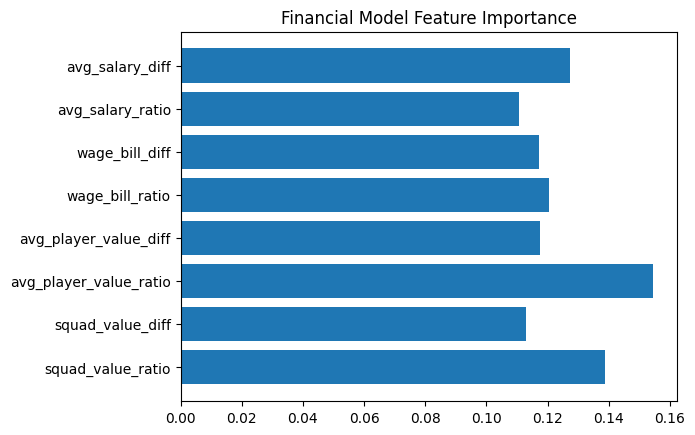

In [64]:
import matplotlib.pyplot as plt

importances = xgb.feature_importances_
plt.barh(financial_features, importances)
plt.title("Financial Model Feature Importance")
plt.show()
